<a href="https://colab.research.google.com/github/SasikaA073/cp-m/blob/main/D2B_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

___
### Import Libraries
___

In [1]:
!pip install livelossplot

In [2]:
from livelossplot import PlotLosses
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


___
### Utility Functions
___



In [3]:
import random
import numpy as np
import torch

def seed_all(seed=42):
    """
    Set the seed for generating random numbers to ensure reproducibility.

    Parameters:
    seed (int): The seed value to be set for the random number generators. Default is 42.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [4]:
import torch.nn.functional as F
from torchvision.transforms import ToTensor

def mse_loss(image1, image2):
    # Convert images to PyTorch tensors
    tensor_image1 = image1
    tensor_image2 = image2

    # Ensure both tensors have the same shape
    if tensor_image1.shape != tensor_image2.shape:
        raise ValueError("Input images must have the same shape.")

    # Calculate MSE for each RGB channel
    mse_r = F.mse_loss(tensor_image1[0], tensor_image2[0])
    mse_g = F.mse_loss(tensor_image1[1], tensor_image2[1])
    mse_b = F.mse_loss(tensor_image1[2], tensor_image2[2])

    # Calculate the overall MSE
    mse = (mse_r + mse_g + mse_b) / 3.0

    return mse.item()

In [5]:
# Convert tensor to a PIL image
tensor_to_pil = v2.ToPILImage()

In [6]:

def showImages_side_by_side(image1, image2, image1_title, image2_title):
  # image
  # Calculate MSE loss
    loss = mse_loss(image1, image2)
    print(f"Image 1: {image1_title}")
    print(f"Image 2: {image2_title}")
    print(f"MSE Loss: {loss}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots
    axes[0].imshow(tensor_to_pil(image1))  # Show the first image on the left subplot
    axes[0].axis('off')  # Hide axis for the left subplot
    axes[0].set_title(image1_title)  # Set title for the left subplot

    axes[1].imshow(tensor_to_pil(image2))  # Show the second image on the right subplot
    axes[1].axis('off')  # Hide axis for the right subplot
    axes[1].set_title(image2_title)  # Set title for the right subplot

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [7]:
# prompt: cuda else cpu




In [8]:
def check_cuda():
  # Get the current GPU device
  global device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Check if CUDA is available
  if torch.cuda.is_available():
      print("CUDA is available!")

      # Get the number of available GPUs
      global num_devices
      num_devices = torch.cuda.device_count()
      print(f"Number of available GPUs: {num_devices}")

      current_device = torch.cuda.current_device()
      print(f"Current GPU device: {current_device}")

      # Get the name of the GPU
      global gpu_name
      gpu_name = torch.cuda.get_device_name(current_device)
      print(f"GPU name: {gpu_name}")
  else:
      print("CUDA is not available. Using CPU.")

# Example usage
check_cuda()

CUDA is available!
Number of available GPUs: 1
Current GPU device: 0
GPU name: Tesla T4


In [9]:
# Function to show tensor image
def showImage(tensoredImage):

  # Display the image using Matplotlib
  plt.imshow(tensor_to_pil(tensoredImage))
  plt.axis('off')  # Hide axis ticks and labels
  plt.show()

In [10]:
def showImages3(image1, image2,image3, image1_title, image2_title, image3_title, save_path):
    axis_show = "off"
    fig, axes = plt.subplots(1, 3, figsize=(10,5))  # Create a figure with two subplots
    axes[0].imshow(tensor_to_pil(image1))  # Show the first image on the left subplot
    axes[0].axis(axis_show)  # Hide axis for the left subplot
    axes[0].set_title(image1_title)  # Set title for the left subplot

    axes[1].imshow(tensor_to_pil(image2))  # Show the second image on the right subplot
    axes[1].axis(axis_show)  # Hide axis for the right subplot
    axes[1].set_title(image2_title)  # Set title for the right subplot

    axes[2].imshow(tensor_to_pil(image3))  # Show the second image on the right subplot
    axes[2].axis(axis_show)  # Hide axis for the right subplot
    axes[2].set_title(image3_title)  # Set title for the right subplot

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(save_path)  # Save the entire figure to a file
    plt.show()

In [11]:
# from itertools import zip_longest

# for noisy_test_batch, clean_test_batch in zip_longest(noisy_test_data_loader, clean_test_data_loader):
#   print(noisy_test_batch.shape, clean_test_batch.shape)

#   for i in range(noisy_test_batch.shape[0]):
#     noisy_test_img = noisy_test_batch[i]
#     clean_test_img = clean_test_batch[i]
#     showImages_side_by_side(noisy_test_img, clean_test_img, f"noisy{i}", f"clean{i}")

#     if i == 1:
#       break


In [12]:
def get_conv_output_size(input_width, kernel_width, padding, stride, in_channels, out_channels):
  """
  Calculate the output size of a convolutional layer.

  Parameters:
  - input_width (int): Size of the input feature map.
  - kernel_width (int): Size of the convolutional kernel.
  - padding (int): Padding added to the input feature map.
  - stride (int): Stride of the convolution.

  Returns:
  - output_size (int): Size of the output feature map.
  """
  output_width = ((input_width - kernel_width + 2 * padding) // stride) + 1
  print("input_size", (input_width, input_width, in_channels))
  print("output_size", (output_width, output_width, out_channels))

input_size = get_conv_output_size(200, 3, 1, 1,in_channels=3, out_channels=32)

input_size (200, 200, 3)
output_size (200, 200, 32)


In [13]:
# Ensure repeatability
seed_all(42)

___
### Download Dataset
___



In [14]:
# Download dataset
!gdown --id 1E1rGvhzu0oWMuake4NBDbrKWZOVzDrFP

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1E1rGvhzu0oWMuake4NBDbrKWZOVzDrFP
From (redirected): https://drive.google.com/uc?id=1E1rGvhzu0oWMuake4NBDbrKWZOVzDrFP&confirm=t&uuid=0f754f39-f5b3-4cf3-83e1-e65c0a03c7d7
To: /content/LOLdataset.zip
100% 347M/347M [00:13<00:00, 26.3MB/s]


In [15]:
# unzip LOLDataset.zip

!unzip LOLdataset

Archive:  LOLdataset.zip
   creating: eval15/
   creating: eval15/high/
  inflating: eval15/high/748.png     
   creating: __MACOSX/
   creating: __MACOSX/eval15/
   creating: __MACOSX/eval15/high/
  inflating: __MACOSX/eval15/high/._748.png  
  inflating: eval15/high/665.png     
  inflating: __MACOSX/eval15/high/._665.png  
  inflating: eval15/high/111.png     
  inflating: __MACOSX/eval15/high/._111.png  
  inflating: eval15/high/493.png     
  inflating: __MACOSX/eval15/high/._493.png  
  inflating: eval15/high/22.png      
  inflating: __MACOSX/eval15/high/._22.png  
  inflating: eval15/high/23.png      
  inflating: __MACOSX/eval15/high/._23.png  
  inflating: eval15/high/669.png     
  inflating: __MACOSX/eval15/high/._669.png  
  inflating: eval15/high/547.png     
  inflating: __MACOSX/eval15/high/._547.png  
  inflating: eval15/high/778.png     
  inflating: __MACOSX/eval15/high/._778.png  
  inflating: eval15/high/55.png      
  inflating: __MACOSX/eval15/high/._55.png  
  i

In [16]:
class upperLeftCornerCrop(object):
    def __call__(self, img):
        # Ensure the input is a PIL Image
        if not isinstance(img, Image.Image):
            raise TypeError("Input image should be a PIL Image. Got {}".format(type(img)))

        # Crop the image to 200x200 pixels from the upper-left corner
        cropped_img = img.crop((0, 0, 200, 200))
        return cropped_img

In [17]:
img_transform = v2.Compose([
    upperLeftCornerCrop(), # Crop the image to 200x200 pixels from the upper-left corner
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), # normalise the image matrix (Convert PIL image 0-255 -> 0-1)
])


In [18]:
class LOLDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [19]:
train_bright_dataset = LOLDataset("/content/our485/high/", transform=img_transform)
train_dark_dataset = LOLDataset("/content/our485/low/", transform=img_transform)

val_bright_dataset = LOLDataset("/content/eval15/high/", transform=img_transform)
val_dark_dataset = LOLDataset("/content/eval15/low/", transform=img_transform)

In [20]:
batch_size = 64 # for testing changed this to 1 from 64
shuffle = False

train_dark_dataloader = DataLoader(train_dark_dataset, batch_size=batch_size, shuffle=shuffle)
train_bright_dataloader = DataLoader(train_bright_dataset, batch_size=batch_size, shuffle=shuffle)

# Test data loader
val_dark_dataloader = DataLoader(val_dark_dataset, batch_size=batch_size, shuffle=shuffle)
val_bright_dataloader = DataLoader(val_bright_dataset, batch_size=batch_size, shuffle=shuffle)

___
### Model Architecture
___



In [21]:
import torch.nn as nn
import torch.nn.functional as F
import copy

# define the NN architecture
class VGG19_CONV_DENOISER(nn.Module):
    def __init__(self):
        super(VGG19_CONV_DENOISER, self).__init__()
        ## encoder layers ##
        self.encoder = nn.Sequential(
            # in_channels : number of channels per image ; for RGB -> 3
            # out_channels : number of convolutional filters with #in_channel of kernels per filters

            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1,stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32), # number of channels are the features
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1,stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3, padding=1,stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3, padding=1,stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=256),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

            nn.Conv2d(in_channels=256, out_channels=512,kernel_size=3, padding=1,stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=512),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(in_channels=64, out_channels=32,kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1, stride=1),
            nn.Sigmoid()
        )

        self.model = nn.Sequential(
            self.encoder,
            self.decoder
        )


    def forward(self, x):
        return self.model(x)

    def get_encoder_architecture(self):
      print("*** Encoder Architecture")
      print(self.encoder)

    def get_decoder_architecture(self):
      print("*** Decoder Architecture")
      print(self.decoder)

    def debug_encoder(self,x,printDebugOutput=True):
      """Pass thorugh a dataloader with one image per batch"""
      encoder_test_tensor = copy.deepcopy(x)

      if printDebugOutput:
        print("\nPassing thorugh Encoder >>> \n")
        print("Original Image size : ")
        print(encoder_test_tensor.shape)

      for i, layer in enumerate(self.encoder):

        encoder_test_tensor = layer(encoder_test_tensor)

        if printDebugOutput:
          print("layer " ,i, ": ", layer )
          print(encoder_test_tensor.shape)


      return encoder_test_tensor

    def debug_decoder(self,x,printDebugOutput=True):
      """Pass through a dataloader with one image per batch"""
      # decoder_test_tensor = copy.deepcopy(x)
      decoder_test_tensor = x

      if printDebugOutput:
        print("\nPassing thorugh Decoder >>> \n")
        print("Original Input size : ")
        print(decoder_test_tensor.shape)

      for i, layer in enumerate(self.decoder):

        decoder_test_tensor = layer(decoder_test_tensor)

        if printDebugOutput:
          print("layer " ,i, ": ", layer )
          print(decoder_test_tensor.shape)

      return decoder_test_tensor

# initialize the NN
model = VGG19_CONV_DENOISER()

___
### Training
___

Loss can be configured 2 ways.
1. Compute the loss (MSE between clean and reconstructed images)
            loss = criterion(noisy_reconstructed, clean_images) + criterion(clean_reconstructed, clean_images)
2.


In [22]:
isTraining = False

In [23]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [24]:
num_epochs = 40

In [25]:
# Create a live plot instance
liveplot = PlotLosses()

# Initialize an empty list to store the loss values
loss_values = []



In [26]:
# Load Model from the saved checkpoints
autoencoder_model = VGG19_CONV_DENOISER()
autoencoder_model.train()

# Define optimizer and criterion
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()  # Assuming MSE loss for denoising


In [27]:
import os
from PIL import Image

def remove_non_image_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # Attempt to open the file as an image
                with Image.open(file_path) as img:
                    # If successful, continue to the next file
                    pass
            except (IOError, OSError):
                # If the file cannot be opened as an image, it's not an image file
                print(f"Removing non-image file: {file_path}")
                os.remove(file_path)

remove_non_image_files("/content/eval15/")
remove_non_image_files("/content/our485/")

Removing non-image file: /content/eval15/.DS_Store
Removing non-image file: /content/our485/low/.DS_Store
Removing non-image file: /content/our485/high/.DS_Store


In [28]:
# Training loop
if isTraining:
    autoencoder_model.to(device)  # Move the model to the device
    num_epochs = 300
    # save path

    for epoch in range(num_epochs):

        running_loss = 0.0
        for bright_images, dark_images in zip(train_bright_dataloader, train_dark_dataloader):
            # Move data to GPU if available
            bright_images = bright_images.to(device)
            dark_images = dark_images.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            ## forward pass: compute predicted outputs by passing *noisy* images to the model
            # clean_reconstructed = modified_autoencoder_model2(clean_images)
            dark_reconstructed = autoencoder_model(dark_images)

            # Compute the loss (MSE between clean and reconstructed images)
            loss = criterion(dark_reconstructed, bright_images)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

        average_loss = running_loss / len(train_bright_dataloader)
        loss_values.append(average_loss)

        logs = {'loss': average_loss}
        liveplot.update(logs)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {average_loss}")  # Corrected the printing of loss

        if epoch % 25 == 0:  # Save model weights periodically
            model_save_path = f"/content/drive/MyDrive/with_batch_norm_VGG19_CONV_DENOISER_{40+epoch}_epochs.pt"
            torch.save(autoencoder_model.state_dict(), model_save_path)
            print(f"epoch {epoch} : Model was saved...")

        liveplot.draw()

___
### Inference
___



In [30]:
os.listdir("/content/drive/MyDrive/")

['Colab Notebooks',
 'VGG19_CONV_DENOISER_40_epochs.pt',
 'with_batch_norm_VGG19_CONV_DENOISER_40_epochs.pt',
 'with_batch_norm_VGG19_CONV_DENOISER_65_epochs.pt',
 'with_batch_norm_VGG19_CONV_DENOISER_90_epochs.pt',
 'with_batch_norm_VGG19_CONV_DENOISER_115_epochs.pt',
 'with_batch_norm_VGG19_CONV_DENOISER_140_epochs.pt',
 'with_batch_norm_VGG19_CONV_DENOISER_165_epochs.pt',
 'with_batch_norm_VGG19_CONV_DENOISER_190_epochs.pt',
 'with_batch_norm_VGG19_CONV_DENOISER_215_epochs.pt',
 'with_batch_norm_VGG19_CONV_DENOISER_240_epochs.pt',
 'with_batch_norm_VGG19_CONV_DENOISER_265_epochs.pt',
 'with_batch_norm_VGG19_CONV_DENOISER_290_epochs.pt']

In [31]:
# prompt: load model

# Load the model from the saved checkpoint
autoencoder_model = VGG19_CONV_DENOISER()
autoencoder_model.load_state_dict(torch.load("/content/drive/MyDrive/with_batch_norm_VGG19_CONV_DENOISER_290_epochs.pt"))
autoencoder_model.eval()  # Set the model to evaluation mode


VGG19_CONV_DENOISER(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True,

torch.Size([15, 3, 200, 200]) torch.Size([15, 3, 200, 200])
Image 1: noisy0
Image 2: clean0
MSE Loss: 0.10173771530389786


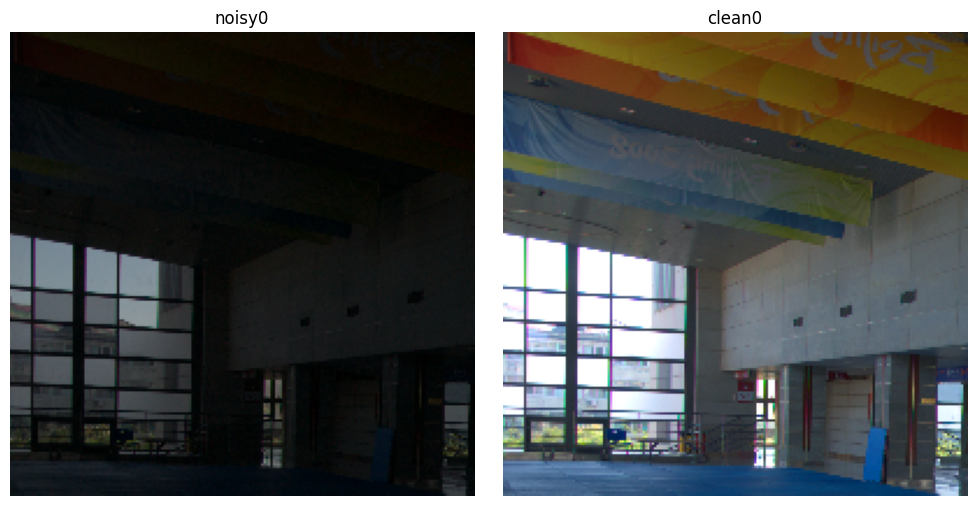

Image 1: noisy1
Image 2: clean1
MSE Loss: 0.08793177455663681


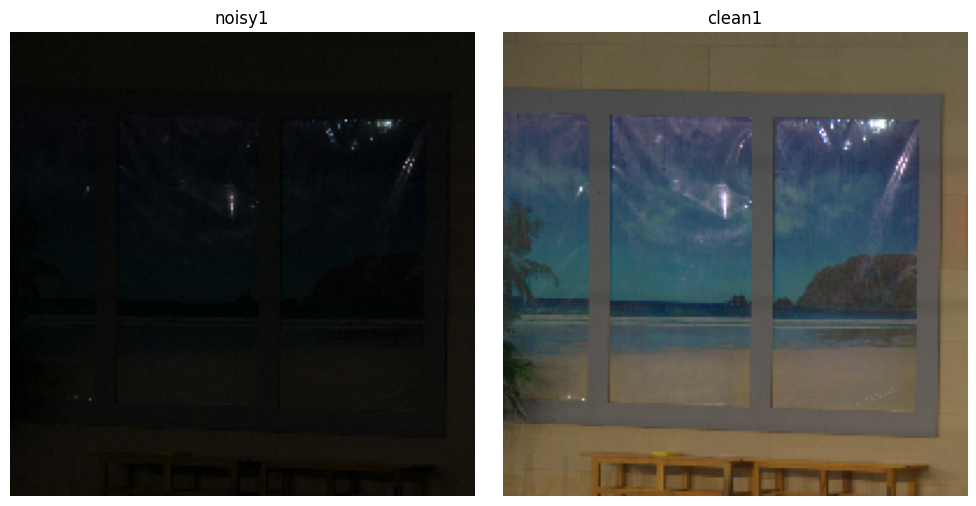

In [33]:
from itertools import zip_longest

for noisy_test_batch, clean_test_batch in zip_longest(val_dark_dataloader, val_bright_dataloader):
  print(noisy_test_batch.shape, clean_test_batch.shape)

  for i in range(noisy_test_batch.shape[0]):
    noisy_test_img = noisy_test_batch[i]
    clean_test_img = clean_test_batch[i]
    showImages_side_by_side(noisy_test_img, clean_test_img, f"noisy{i}", f"clean{i}")

    if i == 1:
      break


torch.Size([15, 3, 200, 200]) torch.Size([15, 3, 200, 200])

noisy_test_batch is on cuda:0
clean_test_batch is on cuda:0
cuda:0
Model is on CUDA (GPU)
noisy_reconstructed_batch is on cuda:0


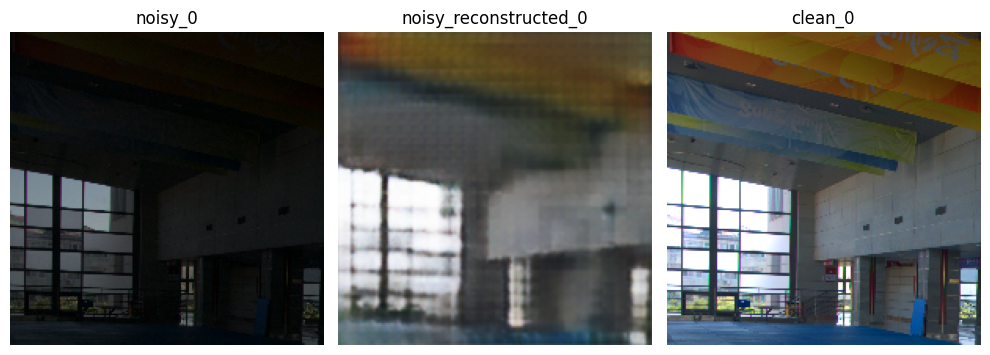

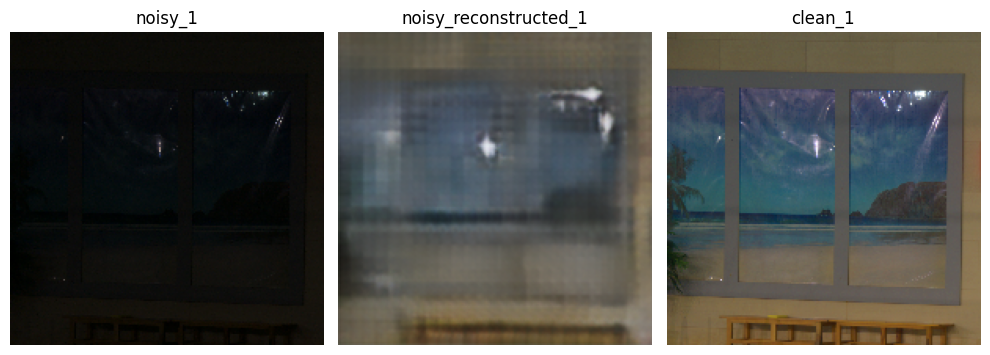

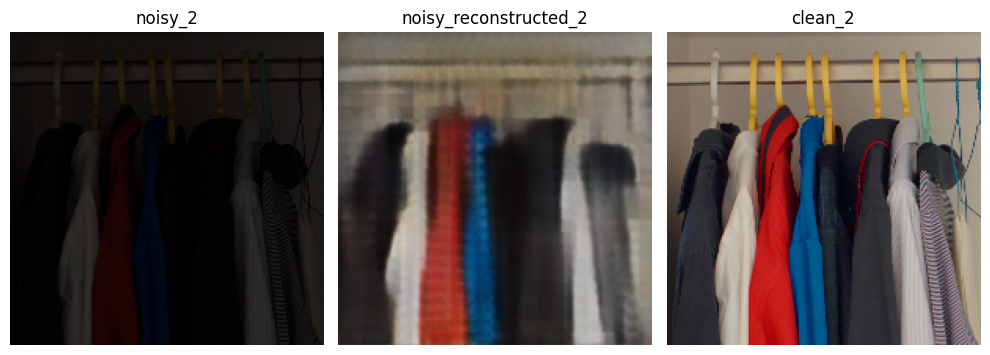

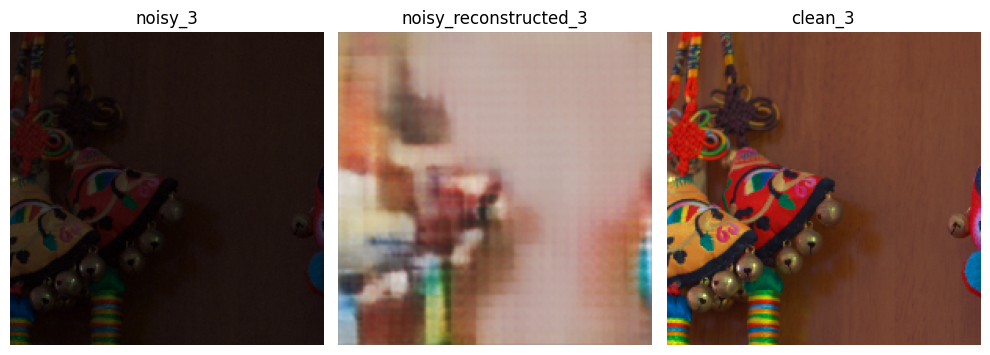

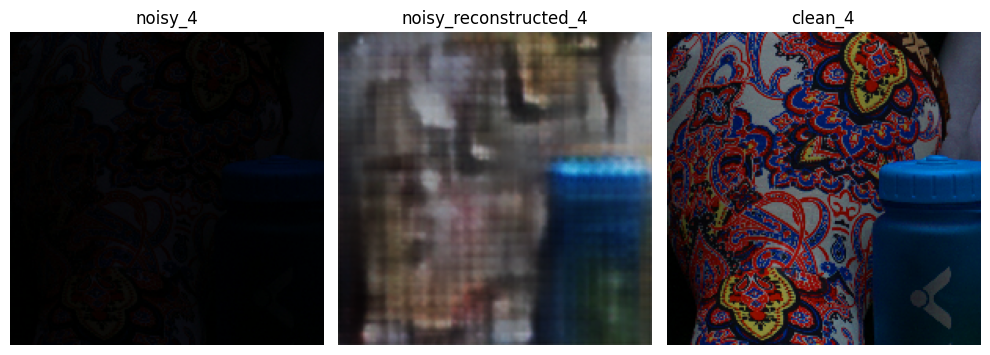

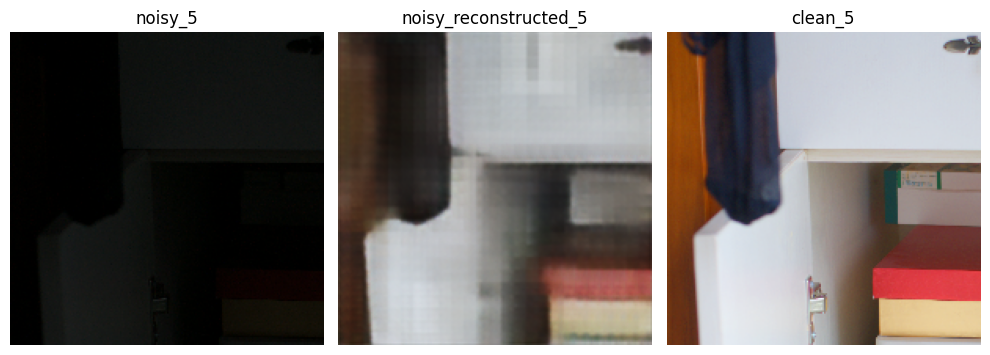

In [34]:
from itertools import zip_longest

autoencoder_model.eval()

noisy_test_batch = noisy_test_batch.to(device)
modified_autoencoder_model = autoencoder_model.to(device)

for noisy_test_batch, clean_test_batch in zip_longest(val_dark_dataloader, val_bright_dataloader):
    print(noisy_test_batch.shape, clean_test_batch.shape)
    print()
    noisy_test_batch = noisy_test_batch.to("cuda")
    clean_test_batch = clean_test_batch.to("cuda")
    print(f"noisy_test_batch is on {noisy_test_batch.device}")
    print(f"clean_test_batch is on {clean_test_batch.device}")

    print(device)
    if next(autoencoder_model.parameters()).is_cuda:
        print("Model is on CUDA (GPU)")
    else:
        print("Model is on CPU")
    dark_reconstructed = autoencoder_model(noisy_test_batch)

    print(f"noisy_reconstructed_batch is on {dark_reconstructed.device}")


    for i in range(noisy_test_batch.shape[0]):
        noisy_test_img = noisy_test_batch[i]
        noisy_recons_img = dark_reconstructed[i]
        clean_test_img = clean_test_batch[i]
        showImages3(noisy_test_img, noisy_recons_img, clean_test_img, f"noisy_{i}", f"noisy_reconstructed_{i}", f"clean_{i}",save_path=f"/content/drive/MyDrive/Colab Notebooks/attempt_4_loss_b_only_noisy_clean_40_epochs{i}.png" )
        # pass

        if i == 5:
            break


___
### Loss Function Defining
___
